In [168]:
import pandas as pd
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt

with open('../data/ligue1/3900498.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
dataf = pd.DataFrame(data)
df = pd.json_normalize(data)

print(df)


                                        id  index  period     timestamp  \
0     121f98c5-7f79-4a71-8a51-3551683786eb      1       1  00:00:00.000   
1     487fefe3-3a7c-41e0-8745-160d2b151a8e      2       1  00:00:00.000   
2     8b5594fa-6255-4a01-b89a-606a3cefb252      3       1  00:00:00.000   
3     ba47495d-4555-4b05-bcc7-6f21473cb58b      4       1  00:00:00.000   
4     78f70c19-ac15-4c3a-9ff1-6c3682c0aa8e      5       1  00:00:00.656   
...                                    ...    ...     ...           ...   
3735  89b5efc8-7e04-43d2-bf34-0ccaeb0010b7   3736       2  00:48:48.231   
3736  1279c4f6-22ae-4d70-a999-a746a3be65c1   3737       2  00:49:07.587   
3737  33e8646b-40e4-48be-ba99-f99e27c59a0b   3738       2  00:49:09.080   
3738  7111bc45-1bd6-424d-92d1-d0f0e23e408c   3739       2  00:49:10.719   
3739  dd769005-d21a-4145-b7a1-c75c5452fc09   3740       2  00:49:10.719   

      minute  second  possession  duration  type.id    type.name  ...  \
0          0       0      

In [169]:
possession_time = df.groupby('team.name')['duration'].sum()

possession_total = possession_time.sum()
print(possession_total)

3384.069829142


In [170]:
possession_pct = round(possession_time/possession_total*100,2)

for equipe, poss in possession_pct.items():
    time = possession_time[equipe]
    minutes = int(time//60)
    secondes = int(time % 60)
    print(f'{equipe}: {poss}% avec {minutes}min {secondes}s')

AS Monaco: 50.26% avec 28min 20s
Angers: 49.74% avec 28min 3s


In [171]:
def stat_team(df, team_name):
    df_team = df[df['team.name'] == team_name]

    stats = {'Équipe': team_name}
    # Score équipe
    shot = df_team[df_team['type.name'] == 'Shot']

    stats['Buts'] = len(shot[shot['shot.outcome.name'] == 'Goal'])

    # Possession des équipes
    stats['Possession (%)'] = round(df_team['duration'].sum()/df['duration'].sum()*100,1)

    # Nombre de tir

    stats['Tirs totaux'] = len(shot)
    stats['Tirs cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Goal', 'Saved'])])
    stats['Tirs non cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Off T', 'Post', 'Wayward', 'Saved To Post'])])
    stats['Tirs contrés'] = len(shot[shot['shot.outcome.name'].isin(['Blocked'])])
    stats['xG'] = round(shot['shot.statsbomb_xg'].sum(),1)

    #Passes
    nbr_pass = df_team[df_team['type.name'] == 'Pass']

    stats['Nombre de passes'] = len(nbr_pass)

    stats['Passes réussies'] = len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])
    stats['Taux passe (%)'] = round(len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])/ len(nbr_pass)*100,1)

    stats['Passes longues'] = len(nbr_pass[nbr_pass['pass.length'] >= 27])
    stats['Passes courtes'] = len(nbr_pass[nbr_pass['pass.length'] < 27])


    pass_loc = nbr_pass.dropna(subset=['location'])
    stats['Passes dernier tiers'] = len(pass_loc[pass_loc['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)>90])

    stats['Passes clés'] = nbr_pass['pass.shot_assist'].notna().sum()

    #Centres
    nbr_centre = nbr_pass[nbr_pass['pass.cross'] == True]
    centre_reussi = nbr_centre[nbr_centre['pass.outcome.name'].isna()]

    stats['Centres'] = len(nbr_centre)
    stats['Centres réussis (%)'] = round(len(centre_reussi)/len(nbr_centre)*100,1) if len(nbr_centre) > 0 else 0    

    centre_loc = nbr_centre.dropna(subset=['location'])
    centre_reu_loc = centre_reussi.dropna(subset=['location'])

    stats['Centres droite'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])
    stats['Centres gauche'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])
    stats['Centres réussis droite (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])> 0 else 0
    stats['Centres réussis gauche (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40]) > 0 else 0

    # Coup de pied arrêté
    nbr_corner = nbr_pass[nbr_pass['pass.type.name'] == 'Corner']
    nbr_coupfranc = nbr_pass[nbr_pass['pass.type.name'] == 'Free Kick']

    stats['Corners'] = len(nbr_corner)
    stats['Coup Franc'] = len(nbr_coupfranc) + len(shot[shot['shot.type.name'] == 'Free Kick'])

    #Hors jeu

    nbr_horsjeu = df_team[df_team['type.name'] == 'Offside']

    stats['Hors-jeu'] = len(nbr_horsjeu)

    #Fautes
    nbr_faute = df_team[df_team['type.name'] == 'Foul Committed']
    stats['Fautes commises'] = len(nbr_faute)

    if 'foul_won.penalty' in df_team.columns:
        nbr_penalty = df_team[df_team['foul_won.penalty'] == True]
        stats['Penalty'] = len(nbr_penalty)
    else:
        stats['Penalty'] = 0
    
    

    #Duels
    nbr_duel = df_team[df_team['type.name'] == 'Duel']
    nbr_duel_nettoyé = nbr_duel[nbr_duel['duel.outcome.name'].notna()]
    nbr_duelaerienper = len(nbr_duel[nbr_duel['duel.type.name'] == 'Aerial Lost'])
    nbr_duelaeriengag = len(df_team[(df_team['pass.aerial_won'] == True) | (df_team['clearance.aerial_won'] == True) | (df_team['shot.aerial_won'] == True)])

    stats['Duel totaux'] = len(nbr_duel)
    stats['Duel gagnés (%)'] = round(len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])])/len(nbr_duel_nettoyé)*100,1) if len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])]) > 0 else 0

    stats['Duel aériens'] = nbr_duelaeriengag + nbr_duelaerienper
    stats['Duel aérien gagnés (%)'] = round(nbr_duelaeriengag/(nbr_duelaeriengag + nbr_duelaerienper)*100,1) if nbr_duelaeriengag > 0 else 0
    
    #Dribbles
    nbr_dribble = df_team[df_team['type.name'] == 'Dribble']
    nbr_dribblesucc = nbr_dribble[nbr_dribble['dribble.outcome.name'] == 'Complete']

    stats['Dribbles tentés'] = len(nbr_dribble) 
    stats['Dribbles réussis'] = len(nbr_dribblesucc)
    stats['Dribbles réussis (%)'] = round(len(nbr_dribblesucc)/len(nbr_dribble)*100,1) if len(nbr_dribblesucc) > 0 else 0

    #Actions défensives
    nbr_interception = df_team[df_team['interception.outcome.name'].isin(['Success', 'Success In Play', 'Success Out', 'Won'])]
    nbr_clear = df_team[df_team['type.name'] == 'Clearance']
   

    stats['Interceptions'] = len(nbr_interception)
    stats['Dégagement'] = len(nbr_clear)

    if 'block.deflection' in df_team.columns:
        nbr_block = df_team[df_team['block.deflection'] == True]
        stats['Bloc'] = len(nbr_block)
    else :
        stats['Bloc'] = 0
        
    #Arrêts
    nbr_save = df_team[df_team['goalkeeper.type.name'] == 'Shot Saved']

    stats['Arrêts'] = len(nbr_save)

    return stats

teams = df['team.name'].unique()
all_stats = []

for team in teams:
    stats = stat_team(df, team)
    all_stats.append(stats)

stats_df = pd.DataFrame(all_stats)

print(stats_df.T)

                                    0       1
Équipe                      AS Monaco  Angers
Buts                                1       0
Possession (%)                   50.3    49.7
Tirs totaux                        15      15
Tirs cadrés                         2       5
Tirs non cadrés                     7       9
Tirs contrés                        6       1
xG                                2.2     0.8
Nombre de passes                  521     505
Passes réussies                   416     391
Taux passe (%)                   79.8    77.4
Passes longues                    124     114
Passes courtes                    397     391
Passes dernier tiers               65      54
Passes clés                        10      10
Centres                             8       5
Centres réussis (%)              12.5    40.0
Centres droite                      1       2
Centres gauche                      7       3
Centres réussis droite (%)        0.0    50.0
Centres réussis gauche (%)       1

In [173]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

equipe1 = stats_df.iloc[0]
equipe2 = stats_df.iloc[1]

categorie = ['Possession (%)', 'Tirs totaux', 'Tirs cadrés', 'Taux passe (%)', 'Centres', 'Duel gagnés (%)', 'Fautes commises']
categorie = categorie
fig = go.Figure()

fig.add_trace(go.Bar(y=categorie, x=[-equipe1[cat] for cat in categorie], orientation ='h', name=equipe1['Équipe'], marker_color='blue', text= [equipe1[cat] for cat in categorie],  textposition='outside'))
fig.add_trace(go.Bar(y=categorie, x=[equipe2[cat] for cat in categorie], orientation ='h', name=equipe2['Équipe'], marker_color='red', text= [equipe2[cat] for cat in categorie],  textposition='outside'))

fig.update_layout(title=f'{equipe1['Équipe']} {equipe1['Buts']} - {equipe2['Buts']} {equipe2['Équipe']}', barmode='overlay', xaxis= dict(title='', showticklabels=False, zeroline=True, zerolinewidth=2))

fig.show()

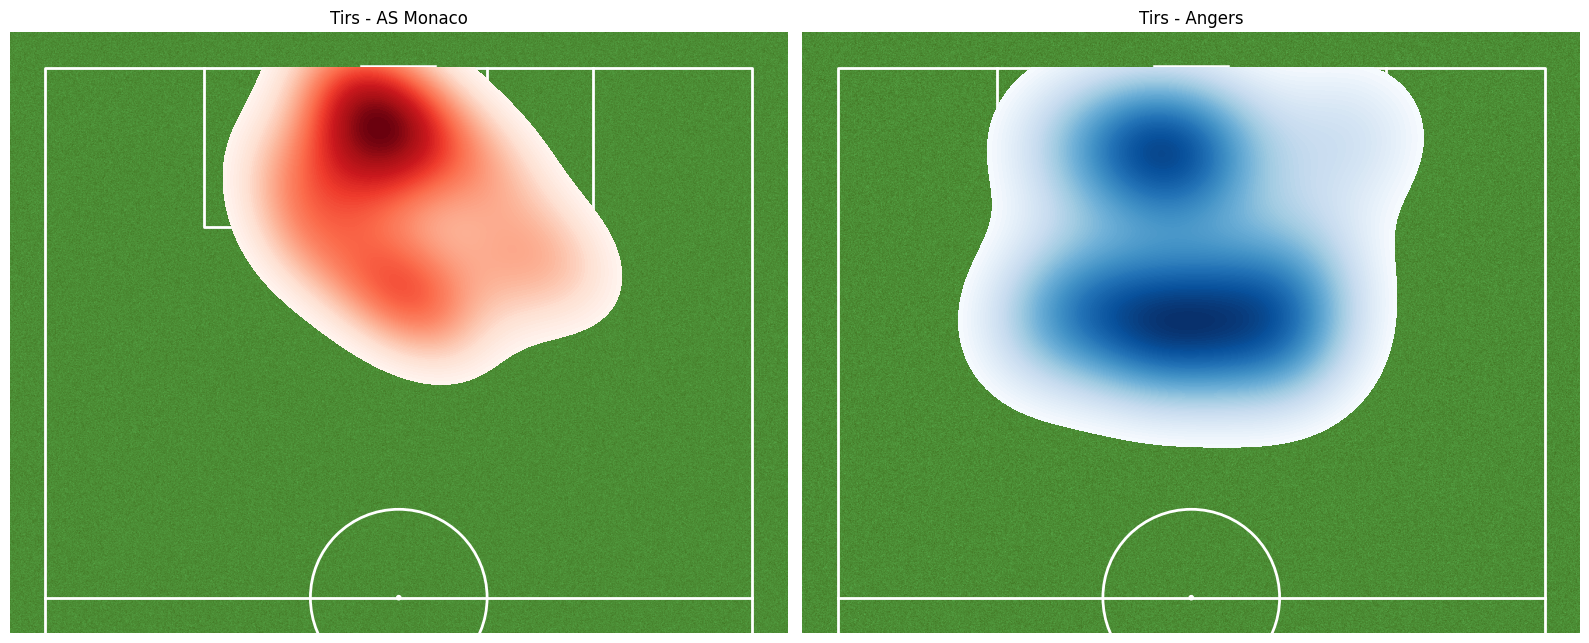

In [184]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

shot = df[df['type.name'] == 'Shot']

equipe1_name = df['team.name'].unique()[0]
equipe2_name = df['team.name'].unique()[1]

shot1 = shot[shot['team.name'] == equipe1_name]
shot2 = shot[shot['team.name'] == equipe2_name]

x1 = shot1['location'].apply(lambda loc: loc[0] if isinstance(loc,list) else None)
y1 = shot1['location'].apply(lambda loc: loc[1] if isinstance(loc,list) else None) 

x2 = shot2['location'].apply(lambda loc: loc[0] if isinstance(loc,list) else None)
y2 = shot2['location'].apply(lambda loc: loc[1] if isinstance(loc,list) else None)

fig, axes = plt.subplots(1,2, figsize=(16,8))

pitch1 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch1.draw(ax=axes[0])
pitch1.kdeplot(x1, y1, ax=axes[0], cmap='Reds', fill=True, levels=100)
axes[0].set_title(f'Tirs - {equipe1_name}', fontsize=12)

pitch2 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch2.draw(ax=axes[1])
pitch2.kdeplot(x2, y2, ax=axes[1], cmap='Blues', fill=True, levels=100)
axes[1].set_title(f'Tirs - {equipe2_name}', fontsize=12)

plt.tight_layout()
plt.show()